In [145]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata


def lat_lon_to_cartesian(lat, lon, radius=6371.0):
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

def create_spatial_map(data):
    lat = np.radians(data['latitude'].values)
    lon = np.radians(data['longitude'].values)
    values = data['pm2.5_atm_a'].values

    # Convert latitude and longitude to Cartesian coordinates
    cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])

    # Ensure cartesian_points has the correct shape
    cartesian_points = cartesian_points.reshape(-1, 3)    

    return cartesian_points[:, :2], values

data = pd.read_csv('../datasets/merged_data_CNN.csv')
data = data[(data['pm2.5_atm_a']<300) & (data['pm2.5_atm_b']<300)]
data_april_1 = data[data['time_stamp'] == '2022-04-01']

spatial_map, values  = create_spatial_map(data_april_1)

In [146]:
spatial_map.shape, values.shape

((44, 2), (44,))

ZeroDivisionError: division by zero

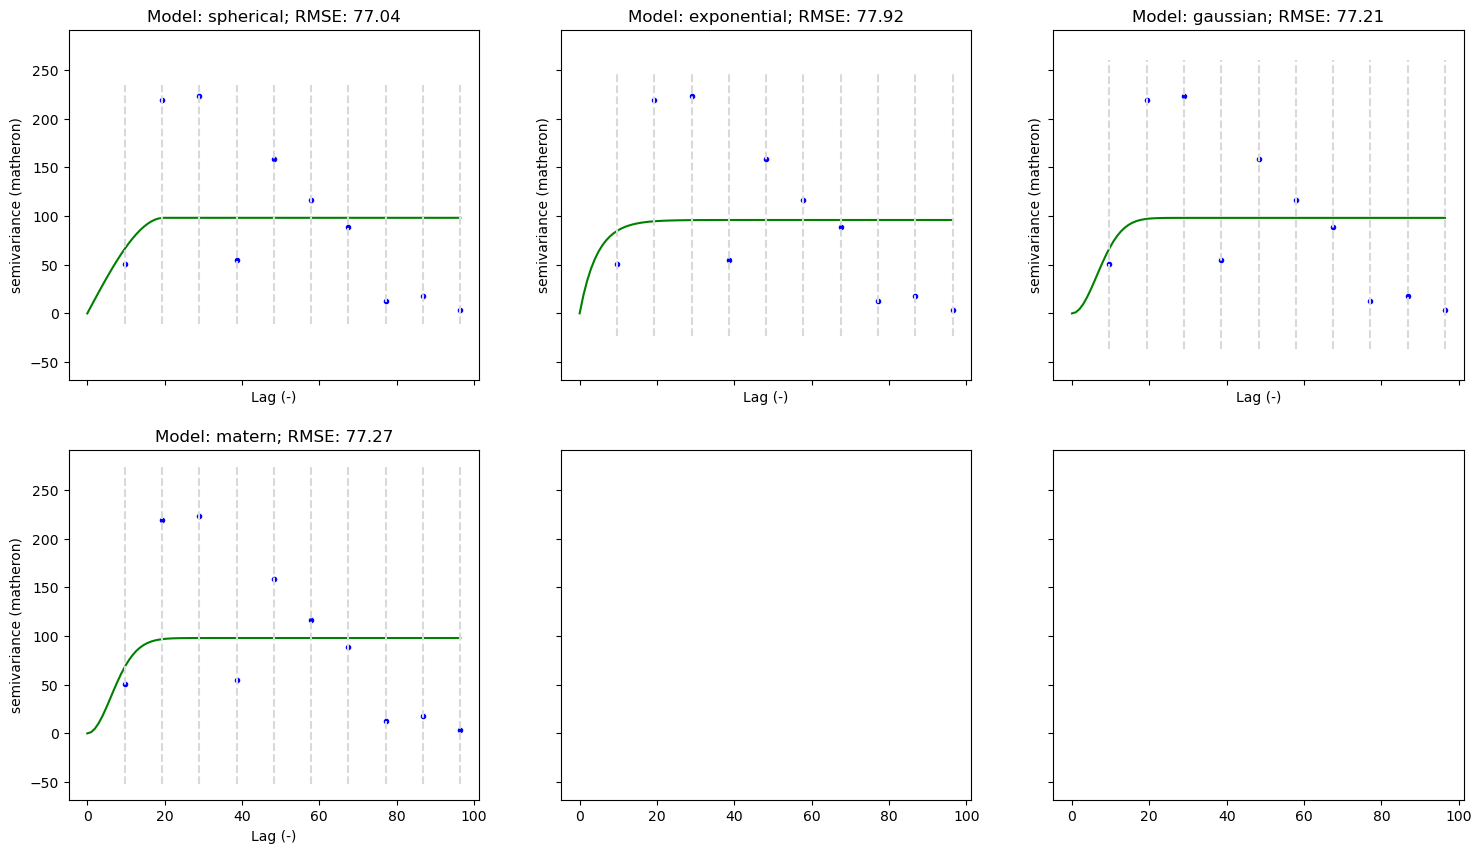

In [150]:
import matplotlib.pyplot as plt
from skgstat import Variogram

V = Variogram(spatial_map, values, normalize=False)

fig, _a = plt.subplots(2,3, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V.rmse))

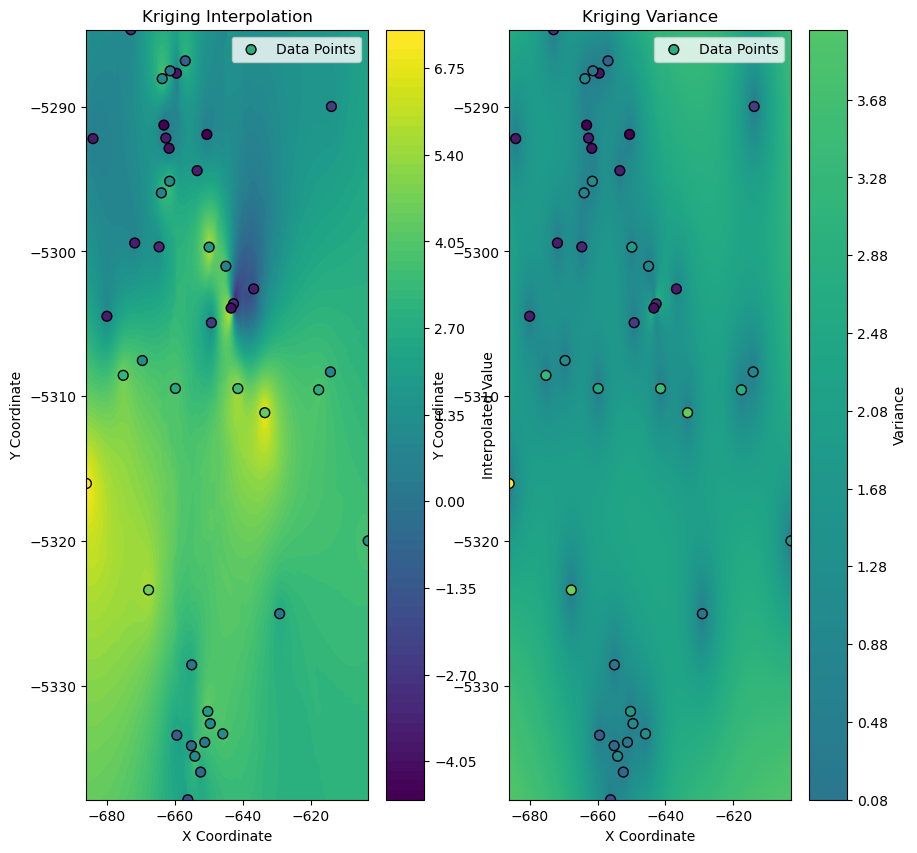

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from skgstat import OrdinaryKriging

# Create a variogram model (assuming this was done earlier)
V = Variogram(spatial_map, values)
V.model = 'stable'

# Perform Ordinary Kriging
ok = OrdinaryKriging(V, min_points=5, max_points=20, mode='estimate')

# Create a grid of unobserved points
grid_x, grid_y = np.meshgrid(
    np.linspace(spatial_map[:, 0].min(), spatial_map[:, 0].max(), 100),
    np.linspace(spatial_map[:, 1].min(), spatial_map[:, 1].max(), 100)
)

# Flatten the grid coordinates
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Perform kriging interpolation
grid_z = ok.transform(grid_points).reshape(grid_x.shape)
sigma = ok.sigma.reshape(grid_x.shape)

v_min = min(grid_z.min(), sigma.min())
v_max = max(grid_z.max(), sigma.max())
# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
contour_z = ax[0].contourf(grid_x, grid_y, grid_z, levels=100, vmin = v_min, vmax = v_max, cmap='viridis')
scatter_z = ax[0].scatter(spatial_map[:, 0], spatial_map[:, 1], c=values, cmap='viridis', edgecolor='k', s=50, label='Data Points')
ax[0].set_xlabel('X Coordinate')
ax[0].set_ylabel('Y Coordinate')
ax[0].set_title('Kriging Interpolation')
ax[0].legend()
fig.colorbar(contour_z, ax=ax[0], label='Interpolated Value')

# Plot Kriging Variance

contour_sigma = ax[1].contourf(grid_x, grid_y, sigma, vmin = v_min, vmax = v_max, levels=100, cmap='viridis')
scatter_sigma = ax[1].scatter(spatial_map[:, 0], spatial_map[:, 1], c=values, cmap='viridis', edgecolor='k', s=50, label='Data Points')
ax[1].set_xlabel('X Coordinate')
ax[1].set_ylabel('Y Coordinate')
ax[1].set_title('Kriging Variance')
ax[1].legend()
fig.colorbar(contour_sigma, ax=ax[1], label='Variance')

plt.show()

In [1]:
import numpy as np
import pandas as pd
from skgstat import Variogram, OrdinaryKriging

def lat_lon_to_cartesian(lat, lon, radius=6371.0):
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

def create_spatial_map(data, timestamp):
    sample_data = data[data['time_stamp'] == timestamp]
    lat = np.radians(sample_data['latitude'].values)
    lon = np.radians(sample_data['longitude'].values)
    values = sample_data['pm2.5_atm_a'].values

    # Convert latitude and longitude to Cartesian coordinates
    cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])
    cartesian_points = cartesian_points.reshape(-1, 3)    
    return cartesian_points[:, :2], values

# Load data
data = pd.read_csv('../datasets/merged_data_CNN.csv')
data = data[(data['pm2.5_atm_a'] < 50) & (data['pm2.5_atm_b'] < 50)]
data = data.dropna(subset=['latitude', 'longitude', 'pm2.5_atm_a'])

# Specify timestamps
timestamp = data['time_stamp'].unique()
# timestamp = ['2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08']
# choose the last 100 timestamps
# timestamp = timestamp[-100:]

processed_data_values = []
processed_data_errors = []

for ts in timestamp:
    spatial_map, values = create_spatial_map(data, ts)
    V = Variogram(spatial_map, values, maxlag=100, n_lags=20, use_nugget=True, max_nfev=5000)
    V.model = 'spherical'
    # print(spatial_map, values)
    # print(V)
    
    try:
        ok = OrdinaryKriging(V, min_points=3, max_points=15, mode='exact')
        
        # Build the target grid
        x = spatial_map[:, 0]
        y = spatial_map[:, 1]
        xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        
        # Perform kriging interpolation
        field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
        sigma = ok.sigma.reshape(xx.shape)
        
        # Append results
        processed_data_values.append((field, xx, yy))
        processed_data_errors.append(sigma)
        
    except ZeroDivisionError:
        print(f'Error processing timestamp {ts}: Division by zero encountered in kriging.')

# processed_data_values now holds the interpolated fields and grid coordinates for each timestamp
# processed_data_errors holds the associated kriging errors



In [158]:
import pickle
with open('processed_data_values.pkl', 'rb') as f:
    data = pickle.load(f)

In [162]:
len(data)

658

In [153]:
# count # of points > 20
np.sum(values > 20)

1

In [2]:
# save the processed data
import pickle
with open('../datasets/processed_data_values.pkl', 'wb') as f:
    pickle.dump(processed_data_values, f)
    
with open('../datasets/processed_data_errors.pkl', 'wb') as f:
    pickle.dump(processed_data_errors, f)
    

In [157]:
len(timestamp)

100

In [156]:
len(processed_data_values)

100

In [29]:
processed_data_values[0][0].shape, processed_data_values[0][1].shape, processed_data_values[0][2].shape

((100, 100), (100, 100), (100, 100))

In [30]:
fields = [item[0] for item in processed_data_values] # List of interpolated fields

data_array = np.stack(fields, axis=0)

data_array = data_array[:, np.newaxis, :, :]  # For PyTorch
# data_array = data_array[:, :, :, np.newaxis] 

In [31]:
data_array.shape

(658, 1, 100, 100)

In [36]:
data_array[11].shape

(1, 100, 100)

In [81]:
time_steps = 10
X, y = [], []
for i in range(len(data_array) - time_steps):
    X.append(data_array[i:i + time_steps])
    y.append(data_array[i + time_steps])

X = np.array(X).reshape(-1, 1,time_steps, 100, 100)
y = np.array(y)
# y = y.reshape(y.shape[0], -1)


In [55]:
len(data_array)

658

In [82]:
X.shape, y.shape

((648, 1, 10, 100, 100), (648, 1, 100, 100))

In [131]:
import torch.nn as nn
import torch

class CNN(nn.Module):
    class Block(nn.Module):
        def __init__(self, in_channels, out_channels, stride=1):
            super().__init__()
            kernel_size = 3
            padding = (kernel_size - 1) // 2
            self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
            self.bn = nn.BatchNorm3d(out_channels)
            self.relu = nn.ReLU()
            
        def forward(self, x):
            return self.relu(self.bn(self.conv(x)))
        
    def __init__(self, channels_l0=64, n_blocks=4, stride=2):
        super().__init__()
        self.cnn_layers = nn.ModuleList()
        
        # First convolutional layer with stride to reduce spatial dimensions
        self.cnn_layers.append(nn.Conv3d(1, channels_l0, kernel_size=5, stride=stride, padding=2))
        self.cnn_layers.append(nn.ReLU())
        
        c1 = channels_l0
        for _ in range(n_blocks):
            c2 = c1 * 2
            block = self.Block(c1, c2, stride=1)  # Keep channels consistent in each block
            self.cnn_layers.append(block)
            c1 = c2  # Update the number of input channels for the next block
        
        # Final convolutional layer before upsampling
        self.cnn_layers.append(nn.Conv3d(c1, c1, kernel_size=3, padding=1))
        self.cnn_layers.append(nn.BatchNorm3d(c1))
        
        # upsampling
        self.cnn_layers.append(nn.ConvTranspose3d(c1, 1, kernel_size=4, stride=stride, padding=1, output_padding=0))
        self.cnn_layers.append(nn.BatchNorm3d(1))
        
        self.cnn = nn.Sequential(*self.cnn_layers)
        
        # A 2D convolutional layer to finalize the output
        self.Conv2d = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        residual = x 
        x = self.cnn(x)
        x = x + residual  # Skip connection
        x = x[:, :, -1, :, :]  # Selecting the last time step
        return self.Conv2d(x)

# Example usage
model = CNN(n_blocks=3, stride=2)
# print(model)
input_tensor = torch.randn(1, 1, 10, 100, 100)

output_image = model(input_tensor)

# Check output shape
print("Output Shape:", output_image.shape)  # Should be [1, 1, 100, 100]


CNN(
  (cnn_layers): ModuleList(
    (0): Conv3d(1, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): Block(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): Block(
      (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): Block(
      (conv): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (5): Conv3d(512, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (6): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cnn): Seq

In [4]:
import pandas as pd
import numpy as np
import sqlite3


In [3]:
# query = """
# SELECT
#     s.sensor_index,
#     s.name,
#     s.latitude,
#     s.longitude,
#     d.time_stamp,
#     d.humidity_a,
#     d.temperature_a,
#     d.pressure_a,
#     d."pm2.5_atm_a",
#     d."pm2.5_atm_b",
#     d."pm2.5_cf_1_a",
#     d."pm2.5_cf_1_b"
# FROM
#     sensor_table AS s
# JOIN
#     data_table AS d
# ON
#     s.sensor_index = d.sensor_index

# """

# with sqlite3.connect('../datasets/dallas.sqlite') as db:
#     data = pd.read_sql(query, db)

In [4]:
# data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [5]:
# data.set_index('time_stamp', inplace=True)
# data =  data.sort_index(ascending=True)


In [6]:
# data.index = data.index.date # change index to date format

In [7]:
# # Merging weather data from noaa to the data from a single sensor
# weather_noaa_data = pd.read_csv('../datasets/Dallas_stations_data.csv')

# weather_noaa_data_w =  weather_noaa_data[weather_noaa_data['STATION']=='USW00003971'][['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'DAPR', 'MDPR', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG','TMAX','TMIN', 'WDF2','WDF5', 'WESD', 'WESF','WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06','WT08']]

# weather_noaa_data_w_n = weather_noaa_data_w[:-2] # the noaa data is for two days longer

# weather_noaa_data_w_n = weather_noaa_data_w_n.fillna(0) # lot's of NAN values, which are essentially zeros

In [8]:
# weather_noaa_data_w_n['DATE'] = pd.to_datetime(weather_noaa_data_w_n['DATE'])
# weather_noaa_data_w_n.set_index('DATE', inplace=True) # setting index makes it easier to merge later

In [9]:
# merged_df = pd.merge(data, weather_noaa_data_w_n, how = 'left', left_index=True, right_index=True)

In [10]:
# start_date = '2022-04-01'
# end_date = '2024-03-29'

# # Filter the DataFrame for rows within the specified range
# filtered_merged_df = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]


In [11]:
# Reset the index and rename the index column
# filtered_merged_df = filtered_merged_df.reset_index().rename(columns={'index': 'time_stamp'})

In [12]:
# filtered_merged_df

In [13]:
# filtered_merged_df = filtered_merged_df[filtered_merged_df['pm2.5_atm_a']<1000]

In [14]:
# filtered_merged_df

In [15]:
# filtered_merged_df.to_csv('../datasets/merged_data_CNN.csv', index=False)

In [5]:
filtered_merged_df = pd.read_csv('../datasets/merged_data_CNN.csv', index_col=False)

In [10]:
filtered_merged_df.head()

,time_stamp,sensor_index,name,latitude,longitude,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,...,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08
0,2022-04-01,87721,Garland,32.963880,-96.634650,31.406,66.424,996.667,4.720,3.450,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-04-01,90785,HeathWeather,32.819980,-96.466545,39.826,61.796,998.508,3.981,3.353,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-04-01,113708,UNT-GEO-56,33.259953,-97.257290,42.803,59.520,990.216,1.014,1.565,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-04-01,127067,UNT-GEO-39,33.149710,-97.126010,38.254,62.729,995.100,0.373,0.606,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-04-01,59903,UNT-GEO-32,33.112953,-97.121280,33.125,66.057,994.619,3.595,4.456,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
filtered_merged_df = filtered_merged_df[(filtered_merged_df['pm2.5_atm_a']<500) & (filtered_merged_df['pm2.5_atm_b']<500)]

In [39]:
from scipy.interpolate import griddata
import numpy as np

# Function to convert latitude and longitude to Cartesian coordinates
def lat_lon_to_cartesian(lat, lon, radius=6371.0):
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

# Function to create a spatial map for a given timestamp
def create_spatial_map(data, timestamp, grid_x, grid_y):
    subset = data[data['time_stamp'] == timestamp]
    lat = np.radians(subset['latitude'].values)
    lon = np.radians(subset['longitude'].values)
    values = subset['pm2.5_atm_a'].values

    # Convert latitude and longitude to Cartesian coordinates
    cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])

    # Ensure cartesian_points has the correct shape
    cartesian_points = cartesian_points.reshape(-1, 3)

    # Interpolate using griddata
    grid_z = griddata(cartesian_points[:, :2], values, (grid_x, grid_y), method='cubic')
    grid_z__clipped = np.clip(grid_z, 0, None)
    

    return grid_z__clipped

# Example dataset ranges
min_latitude = filtered_merged_df['latitude'].min()
max_latitude = filtered_merged_df['latitude'].max()
min_longitude = filtered_merged_df['longitude'].min()
max_longitude = filtered_merged_df['longitude'].max()

# Convert min and max latitude and longitude to radians
min_lat_rad = np.radians(min_latitude)
max_lat_rad = np.radians(max_latitude)
min_lon_rad = np.radians(min_longitude)
max_lon_rad = np.radians(max_longitude)

# Convert the bounding coordinates to Cartesian coordinates
min_x, min_y, _ = lat_lon_to_cartesian(min_lat_rad, min_lon_rad)
max_x, max_y, _ = lat_lon_to_cartesian(max_lat_rad, max_lon_rad)

# Define grid resolution (in Cartesian coordinates)
x_resolution = (max_x - min_x) / 100
y_resolution = (max_y - min_y) / 100

# Create grid points in Cartesian coordinates
grid_x, grid_y = np.meshgrid(np.arange(min_x, max_x, x_resolution), np.arange(min_y, max_y, y_resolution))

# Generate spatial maps for all timestamps
timestamps = filtered_merged_df['time_stamp'].unique()
spatial_maps = [create_spatial_map(filtered_merged_df, ts, grid_x, grid_y) for ts in timestamps]
spatial_maps = np.array(spatial_maps)


# Normalize the spatial maps
# normalization_proportion = np.nanmax(spatial_maps)
# spatial_maps = spatial_maps / normalization_proportion

# Handle potential NaNs in spatial maps
spatial_maps = np.nan_to_num(spatial_maps)

In [15]:
grid_x.shape, grid_y.shape, 

((100, 100), (100, 100))

In [81]:
# Flatten the grid coordinates for easier association
grid_coordinates = np.column_stack((grid_x.ravel(), grid_y.ravel()))

In [57]:
len(spatial_maps)

729

In [40]:
spatial_maps.shape

(729, 100, 101)

In [41]:
time_steps = 10
X, y = [], []
for i in range(len(spatial_maps) - time_steps):
    X.append(spatial_maps[i:i + time_steps])
    y.append(spatial_maps[i + time_steps])

X = np.array(X)[..., np.newaxis]
y = np.array(y)[..., np.newaxis]
y = y.reshape(y.shape[0], -1)

In [42]:
X.shape, y.shape

((719, 10, 100, 101, 1), (719, 10100))

In [43]:
# Train-test split
split_index = int(0.9 * len(X))  # 90% of the data for training, 10% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [44]:
len(X_train)

647

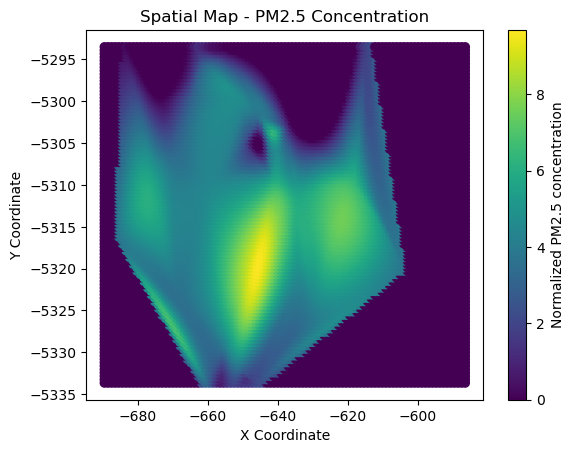

In [25]:
import matplotlib.pyplot as plt

# Select a specific timestamp
timestamp_index = 8

# Plot the PM2.5 values with their corresponding coordinates
plt.scatter(grid_coordinates[:, 0], grid_coordinates[:, 1], c=spatial_maps[timestamp_index].ravel(), cmap='viridis')
plt.colorbar(label='Normalized PM2.5 concentration')
plt.title('Spatial Map - PM2.5 Concentration')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

from sklearn.model_selection import train_test_split


# time_steps = 10
# X = []
# y = []

# for i in range(len(spatial_maps) - time_steps):
#     X.append(spatial_maps[i:i + time_steps])
#     y.append(spatial_maps[i + time_steps])

# X = np.array(X)
# y = np.array(y)
# X.shape
# X = X[..., np.newaxis]
# y = y[..., np.newaxis]

# y = y.reshape(y.shape[0], -1)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train.shape
model = Sequential()
model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(time_steps, 100, 101, 1), padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Change the output layer to match the shape of your target variable
model.add(Dense(100*101*1, activation='linear'))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/home/prahlad/anaconda3/envs/pyml/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [27]:
# Print the model summary
model.summary()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 10, 100, 101,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 50, 50, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 50, 50, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 2, 25, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10100)          │     1,302,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,599,284 (44.25 MB)

 Trainable params: 11,599,284 (44.25 MB)

 Non-trainable params: 0 (0.00 B)

2024-06-07 23:11:14.493467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208868000 exceeds 10% of free system memory.


Epoch 1/10


2024-06-07 23:11:16.652539: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.
2024-06-07 23:11:21.316288: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3:16 12s/step - loss: 149.0132

2024-06-07 23:11:27.422445: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.
2024-06-07 23:11:32.322993: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.


17/17 ━━━━━━━━━━━━━━━━━━━━ 150s 9s/step - loss: 118.3783 - val_loss: 114.4412
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - loss: 88.8851 - val_loss: 45.2485
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - loss: 76.0004 - val_loss: 38.7689
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - loss: 46.6395 - val_loss: 36.3052
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - loss: 61.9952 - val_loss: 33.8829
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - loss: 46.7872 - val_loss: 33.7062
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - loss: 50.1254 - val_loss: 33.4842
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - loss: 56.5114 - val_loss: 33.3505
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - loss: 50.4753 - val_loss: 35.0676
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 964s 10s/step - loss: 38.7545 - val_loss: 39.4649


In [28]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
# model.save('3dcnn_model.h5')

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 745ms/step - loss: 39.2447
Test loss: 39.86933135986328


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Make predictions
y_pred = model.predict(X_test)

# Reshape predictions to the original 2D shape for visualization
y_pred_reshaped = y_pred.reshape(-1, 100, 101)
y_test_reshaped = y_test.reshape(-1, 100, 101)

# Calculate additional performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 844ms/step
Mean Squared Error: 39.86933186808787
Root Mean Squared Error: 6.314216647224568
Mean Absolute Error: 4.111237236722565


In [30]:
np.max(y_test)

104.22879752505787

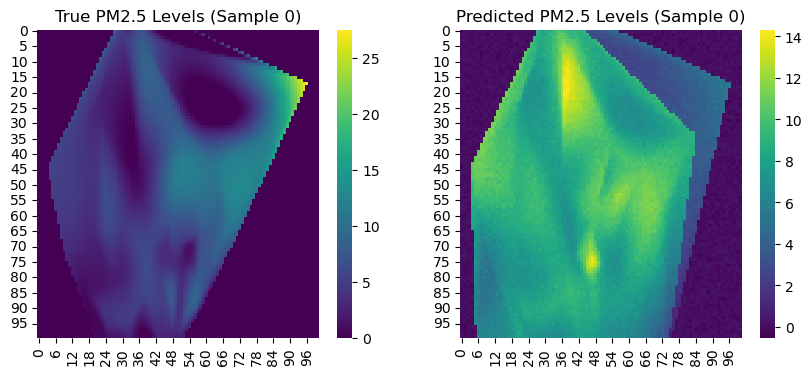

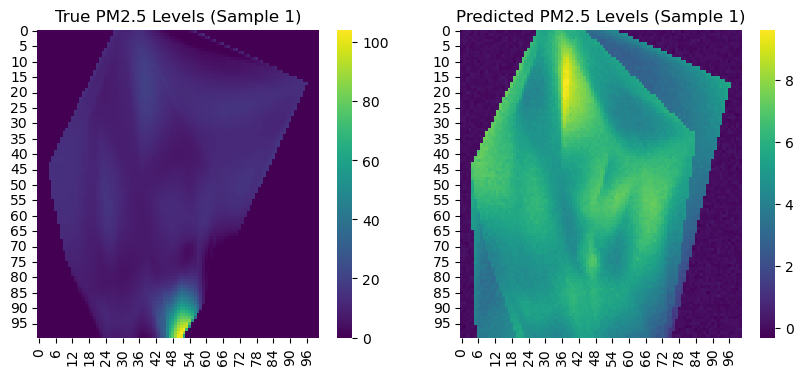

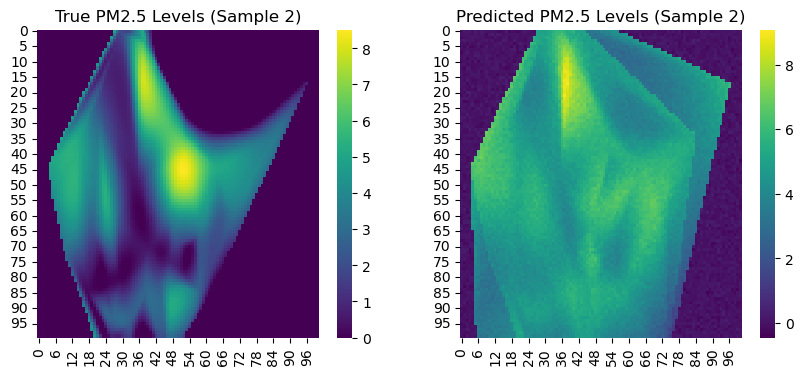

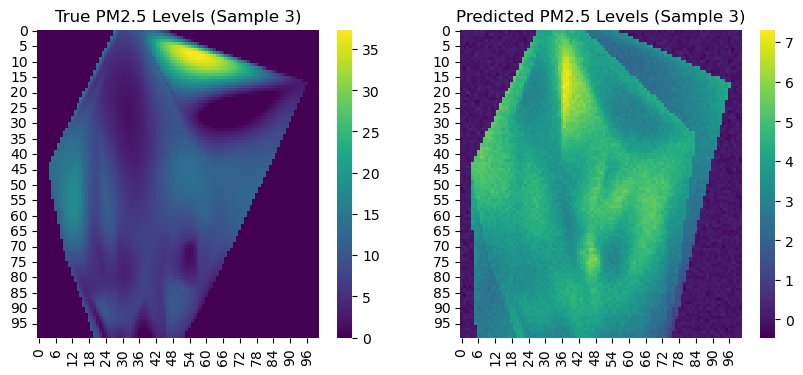

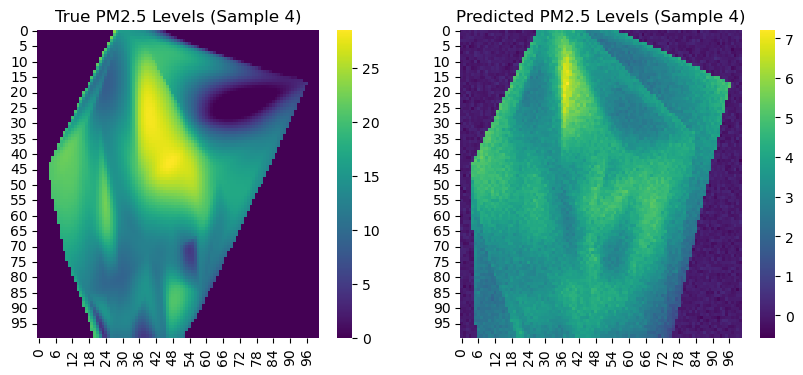

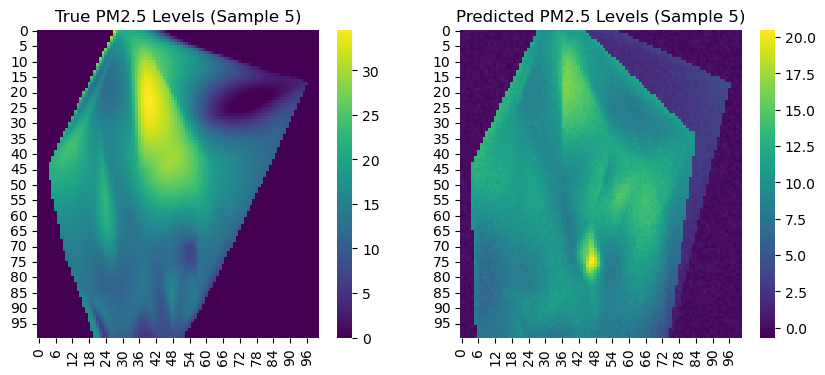

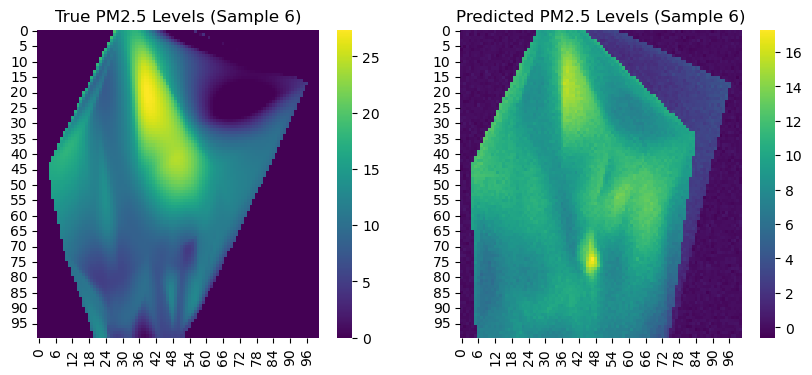

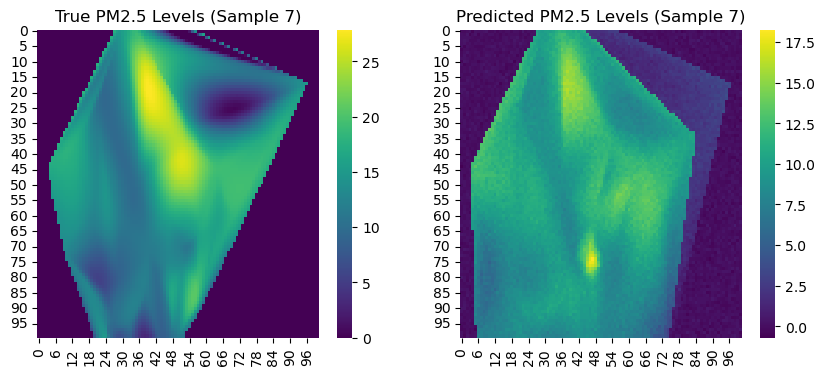

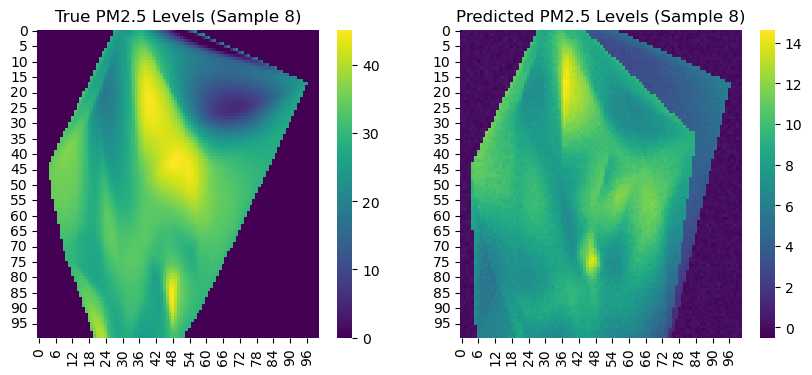

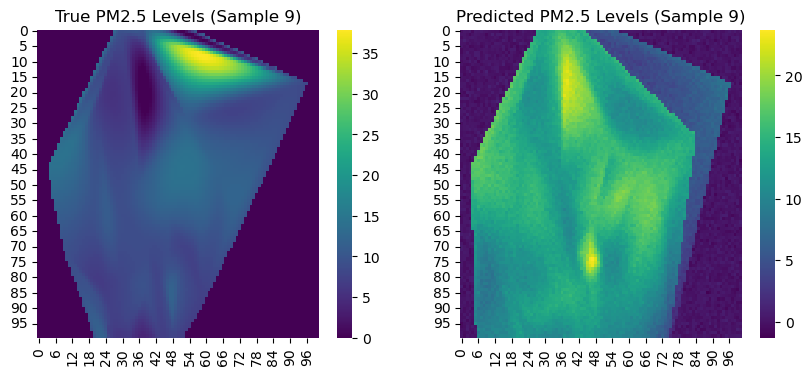

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
num_samples = 10
for i in range(num_samples):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f'True PM2.5 Levels (Sample {i})')
    sns.heatmap(y_test_reshaped[i], cmap='viridis', cbar=True)

    plt.subplot(1, 2, 2)
    plt.title(f'Predicted PM2.5 Levels (Sample {i})')
    sns.heatmap(y_pred_reshaped[i], cmap='viridis', cbar=True)

    plt.show()

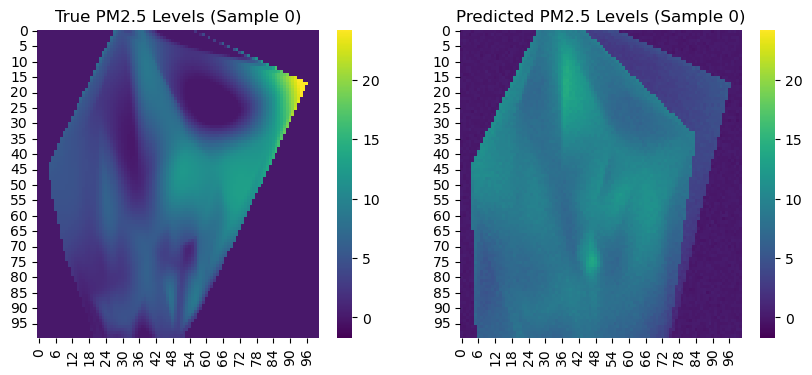

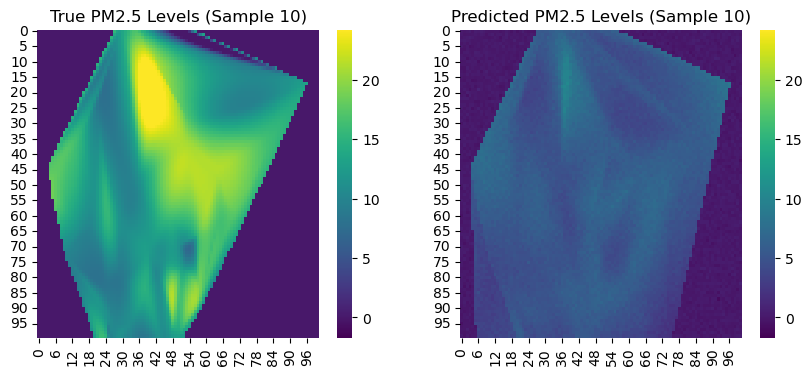

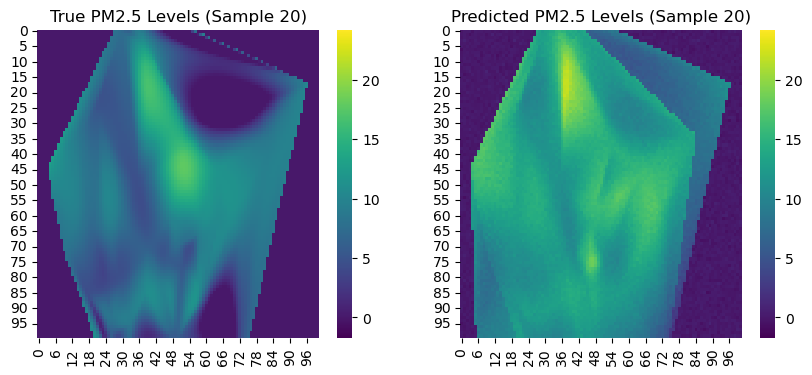

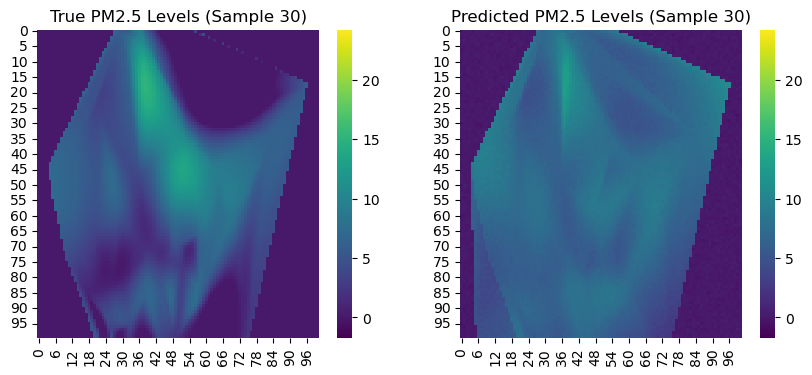

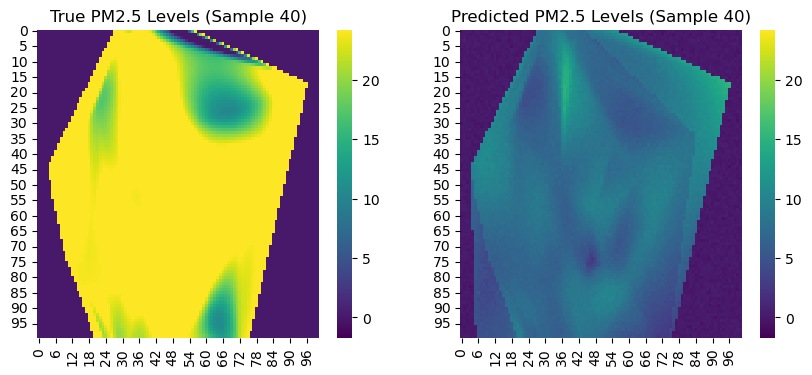

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
num_samples = 5
vmin = min(y_test_reshaped.min(), y_pred_reshaped.min())
vmax = max(y_test_reshaped.max(), y_pred_reshaped.max())

for i in range(0, num_samples*10,10):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f'True PM2.5 Levels (Sample {i})')
    sns.heatmap(y_test_reshaped[i], cmap='viridis', cbar=True, vmin=vmin, vmax=vmax-80)
    # sns.heatmap(y_test_reshaped[i], cmap='viridis', cbar=True)

    plt.subplot(1, 2, 2)
    plt.title(f'Predicted PM2.5 Levels (Sample {i})')
    sns.heatmap(y_pred_reshaped[i], cmap='viridis', cbar=True, vmin=vmin, vmax=vmax-80)

    plt.show()

In [71]:
grid_x

array([[-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       ...,
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731]])

In [72]:
y_pred_reshaped.shape

(72, 100, 101)

In [73]:
len(filtered_merged_df['time_stamp'].unique())

729

In [74]:
unique_sensor_locs = filtered_merged_df[['latitude', 'longitude']].drop_duplicates().values

In [75]:
len(unique_sensor_locs)

67

In [76]:
from scipy.interpolate import griddata

lat = np.radians(unique_sensor_locs[:, 0])
lon = np.radians(unique_sensor_locs[:, 1])

sensor_cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])
sensor_cartesian_points = sensor_cartesian_points.reshape(-1, 3)




In [77]:
sensor_cartesian_points

array([[ -617.5911588 , -5309.55914088,  3466.52619925],
       [ -602.98898029, -5319.98241754,  3453.09026333],
       [ -672.98128193, -5284.69401718,  3494.10164977],
       [ -661.70365335, -5292.88341724,  3483.84477362],
       [ -661.54363808, -5295.15468866,  3480.42207758],
       [ -669.59127204, -5307.53465742,  3459.96595196],
       [ -644.96831919, -5301.0231653 ,  3474.59497902],
       [ -686.08541389, -5316.02472877,  3443.66213325],
       [ -684.14289989, -5292.21354889,  3480.52657588],
       [ -636.75829954, -5302.59005188,  3473.71826861],
       [ -655.12171407, -5334.12971882,  3421.62485999],
       [ -663.24132239, -5291.28046278,  3485.98666269],
       [ -642.72783898, -5303.61827204,  3471.04813414],
       [ -663.73274197, -5288.0734775 ,  3490.7561851 ],
       [ -662.66127526, -5292.17647854,  3484.73659755],
       [ -649.89858693, -5299.70541723,  3475.68630881],
       [ -650.28552191, -5331.76237943,  3426.23403597],
       [ -649.22641036, -5304.9

In [78]:
y_pred.shape

(72, 10100)

In [79]:
predicted_sensor_values = griddata(
    (grid_coordinates[:, 0], grid_coordinates[:, 1]),
    y_pred[0],  
    sensor_cartesian_points[:, :2], 
    method='linear'
)

In [80]:
predicted_sensor_values[0]

14.60763257329996

In [81]:
observed_sensor_values = griddata(
    (grid_coordinates[:, 0], grid_coordinates[:, 1]),
    y_test[0],  
    sensor_cartesian_points[:, :2], 
    method='linear'
)

In [82]:
values_list = []
# Iterate through sensor locations and predicted values
for i, (lat, lon) in enumerate(unique_sensor_locs):
    predicted_pm25 = predicted_sensor_values[i]
    observed_pm25 = observed_sensor_values[i]
    values_list.append({'Latitude': lat, 'Longitude': lon, 'Predicted_PM2.5': predicted_pm25, 'Observed_PM2.5': observed_pm25})
    

pm_values_df = pd.DataFrame(values_list)

# Display the DataFrame
print(pm_values_df)

     Latitude  Longitude  Predicted_PM2.5  Observed_PM2.5
0   32.963880 -96.634650        14.607633       11.781381
1   32.819980 -96.466545         4.552650       12.518811
2   33.259953 -97.257290              NaN             NaN
3   33.149710 -97.126010              NaN             NaN
4   33.112953 -97.121280        10.901662        3.877700
..        ...        ...              ...             ...
62  33.133965 -96.765780        10.495971        1.549711
63  32.960114 -96.692200        13.807204        8.664746
64  32.977444 -96.776110        10.929320        6.683157
65  33.126100 -97.059390         9.887754        4.033196
66  32.456380 -97.006840              NaN             NaN

[67 rows x 4 columns]


In [83]:
# Round both columns to the same significant digits, e.g., 2 significant digits
pm_values_df['Predicted_PM2.5'] = pm_values_df['Predicted_PM2.5'].apply(lambda x: round(x, 5))
pm_values_df['Observed_PM2.5'] = pm_values_df['Observed_PM2.5'].apply(lambda x: round(x, 5))

pm_values_df['Absolute_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']).abs()
pm_values_df['Squared_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']) ** 2
pm_values_df['Percentage_Error'] = (pm_values_df['Absolute_Error'] / pm_values_df['Observed_PM2.5']).abs() * 100

# Display the DataFrame
print(pm_values_df)

     Latitude  Longitude  Predicted_PM2.5  Observed_PM2.5  Absolute_Error  \
0   32.963880 -96.634650         14.60763        11.78138         2.82625   
1   32.819980 -96.466545          4.55265        12.51881         7.96616   
2   33.259953 -97.257290              NaN             NaN             NaN   
3   33.149710 -97.126010              NaN             NaN             NaN   
4   33.112953 -97.121280         10.90166         3.87770         7.02396   
..        ...        ...              ...             ...             ...   
62  33.133965 -96.765780         10.49597         1.54971         8.94626   
63  32.960114 -96.692200         13.80720         8.66475         5.14245   
64  32.977444 -96.776110         10.92932         6.68316         4.24616   
65  33.126100 -97.059390          9.88775         4.03320         5.85455   
66  32.456380 -97.006840              NaN             NaN             NaN   

    Squared_Error  Percentage_Error  
0        7.987689         23.989125  

In [84]:
len(X_train)

647

In [85]:
from datetime import datetime, timedelta

# Define the initial date and the end date
start_date = datetime.strptime('2022-04-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-03-29', '%Y-%m-%d')

# Calculate the 648th day
day_zero = start_date + timedelta(days=len(X_train))

# Generate a list of dates from day_648 to end_date
current_date = day_zero
dates = []

while current_date <= end_date:
    dates.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)

# Return the list of dates
dates

['2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-13',
 '2024-01-14',
 '2024-01-15',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-20',
 '2024-01-21',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-27',
 '2024-01-28',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-03',
 '2024-02-04',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-10',
 '2024-02-11',
 '2024-02-12',
 '2024-02-13',
 '2024-02-14',
 '2024-02-15',
 '2024-02-16',
 '2024-02-17',
 '2024-02-18',
 '2024-02-19',
 '2024-02-20',
 '2024-02-21',
 '2024-02-22',
 '2024-02-23',
 '2024-02-24',
 '2024-02-25',
 '2024-02-26',
 '2024-02-27',
 '2024-02-28',
 '2024-02-29',
 '2024-03-01',
 '2024-03-02',
 '2024-03-03',
 '2024-03-04',
 '2024-03-05',
 '2024-03-06',
 '2024-03-07',
 '2024-03-08',
 '2024-03-09',
 '2024-03-10',
 '2024-03-11',
 '2024-03-12',
 '2024-03-13',
 '2024-03-

IndexError: index 84 is out of bounds for axis 0 with size 72

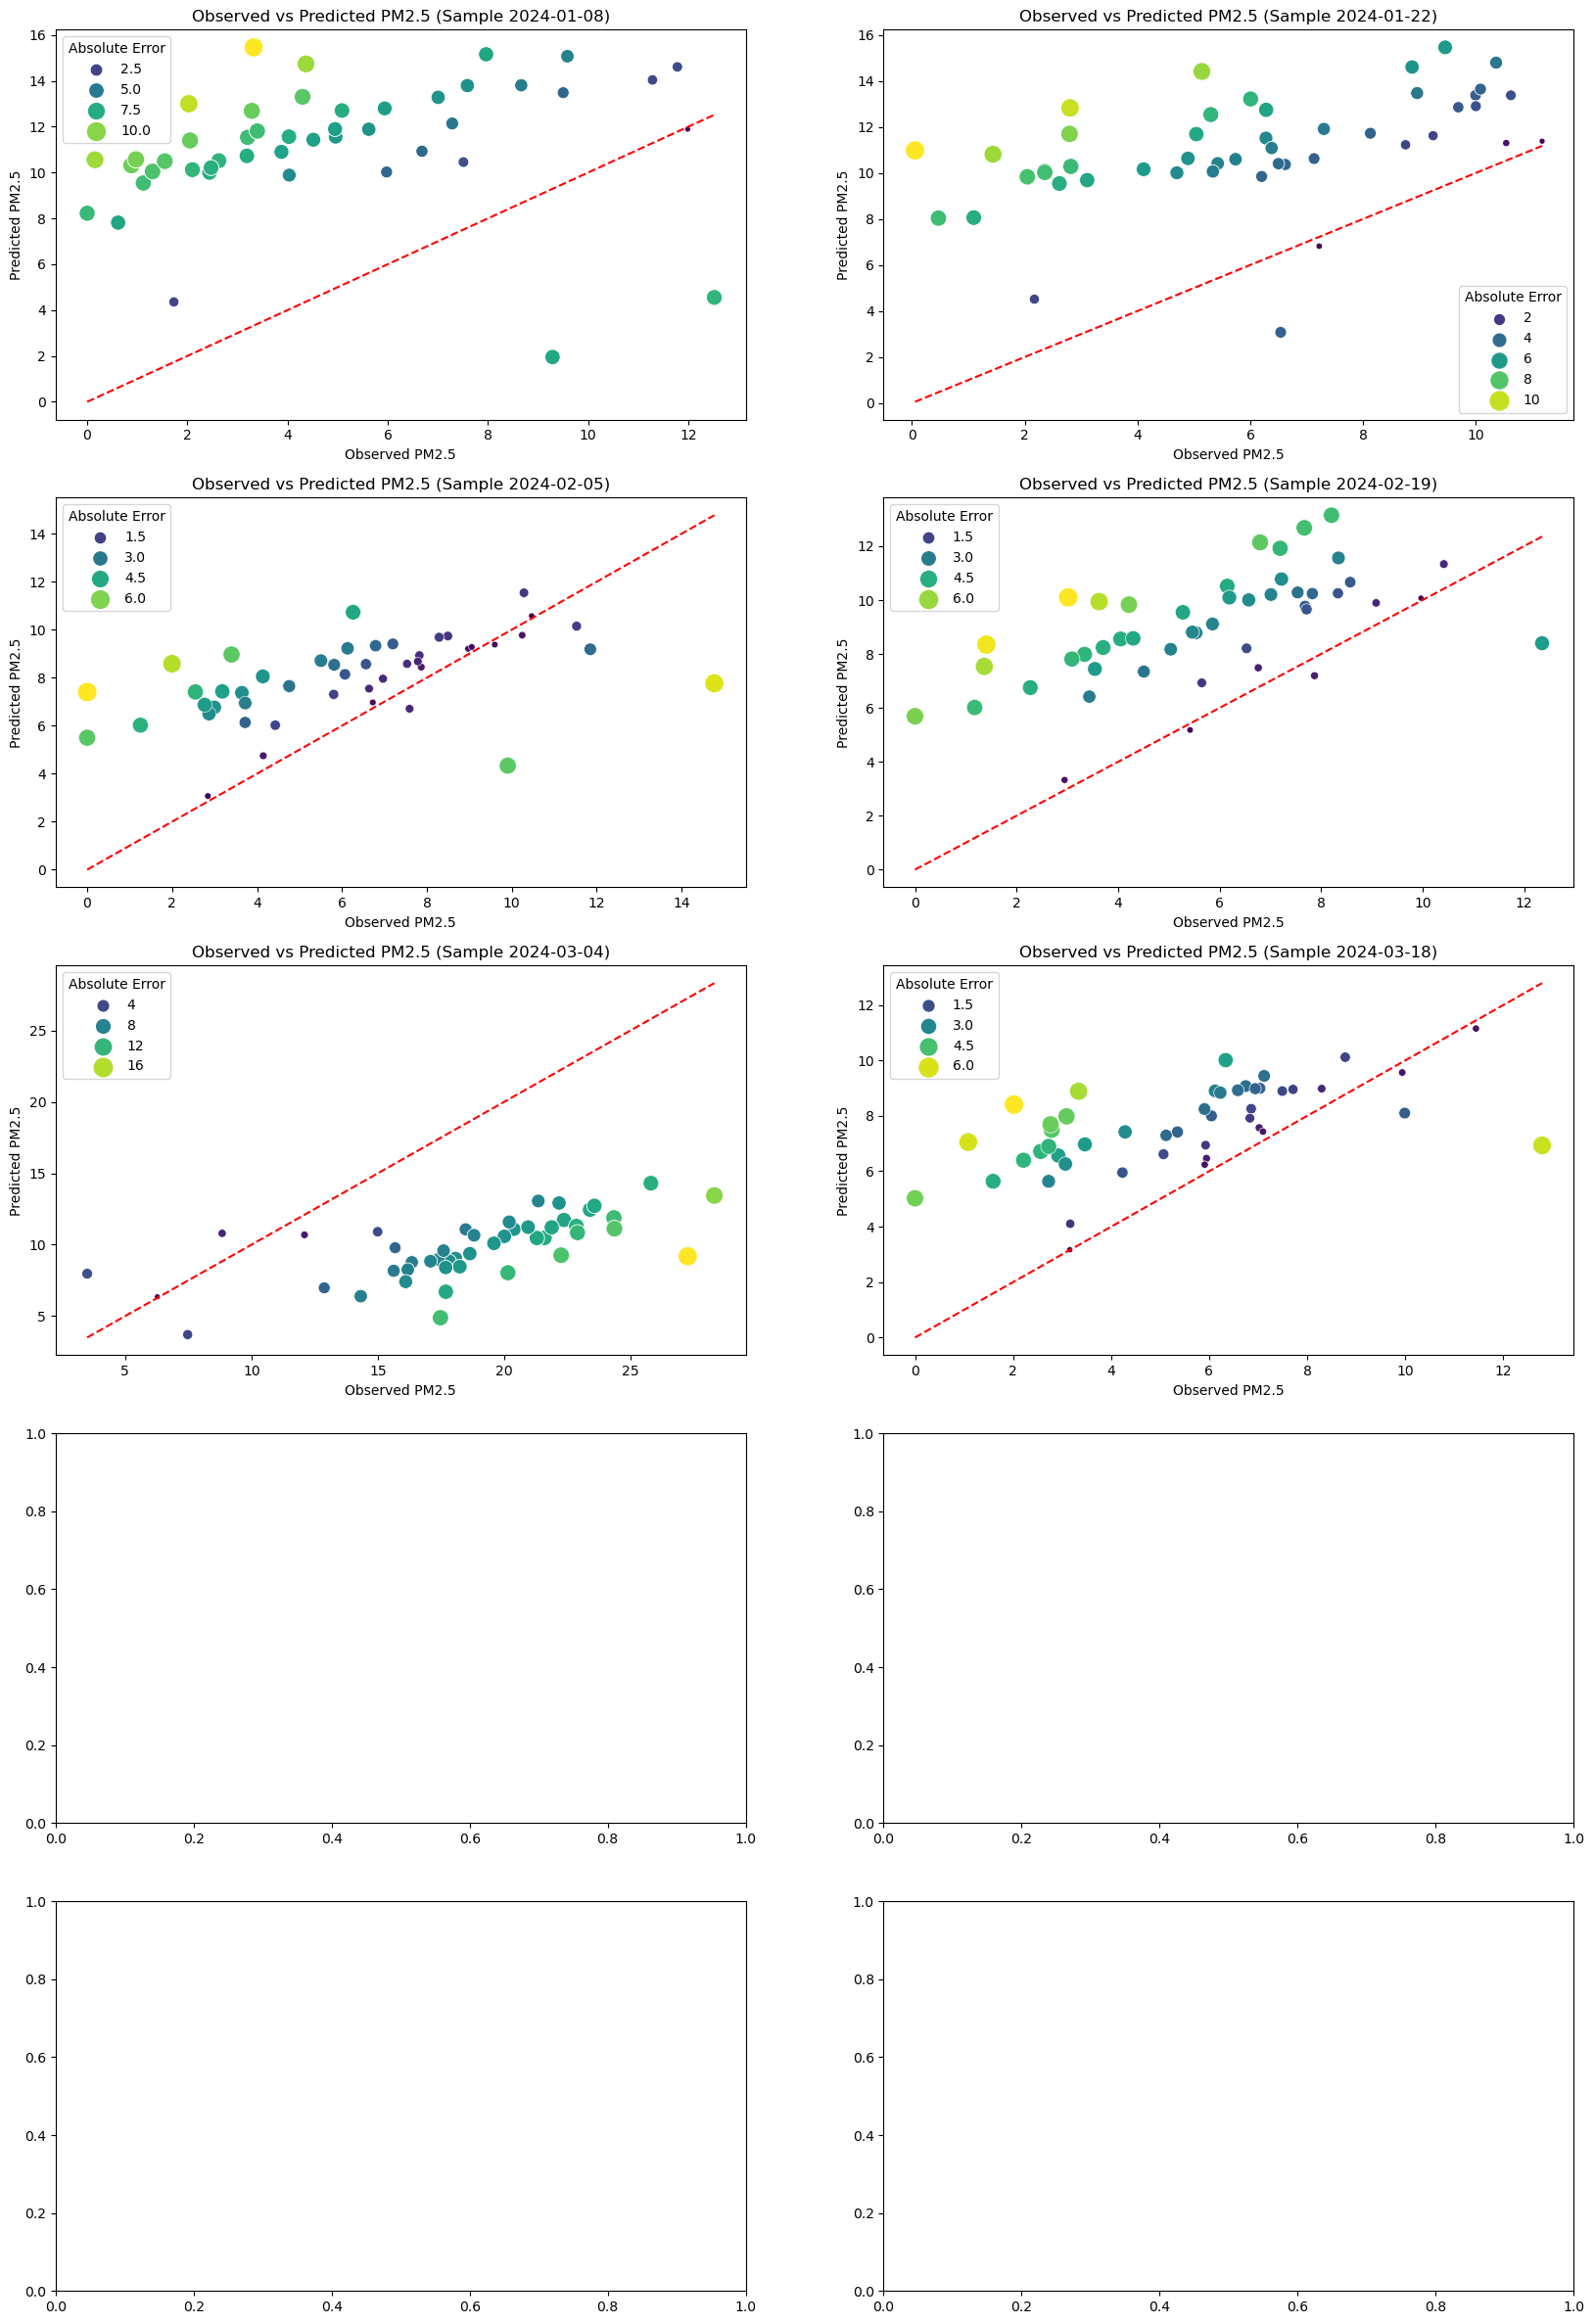

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

num_samples = 10
step_size = 14  # Set the step size to 11
rows = (num_samples + 1) // 2  # Calculate number of rows needed for 2 plots per row

fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for idx, i in enumerate(range(0, num_samples * step_size, step_size)):
    predicted_sensor_values = griddata(
        (grid_coordinates[:, 0], grid_coordinates[:, 1]),
        y_pred[i],  
        sensor_cartesian_points[:, :2], 
        method='linear'
    )
    observed_sensor_values = griddata(
        (grid_coordinates[:, 0], grid_coordinates[:, 1]),
        y_test[i],  
        sensor_cartesian_points[:, :2], 
        method='linear'
    )
    values_list = []
    # Iterate through sensor locations and predicted values
    for j, (lat, lon) in enumerate(unique_sensor_locs):
        predicted_pm25 = predicted_sensor_values[j]
        observed_pm25 = observed_sensor_values[j]
        values_list.append({'Date':dates[i], 'Latitude': lat, 'Longitude': lon, 'Predicted_PM2.5': predicted_pm25, 'Observed_PM2.5': observed_pm25})

    pm_values_df = pd.DataFrame(values_list)

    # Round both columns to the same significant digits, e.g., 5 significant digits
    pm_values_df['Predicted_PM2.5'] = pm_values_df['Predicted_PM2.5'].apply(lambda x: round(x, 5))
    pm_values_df['Observed_PM2.5'] = pm_values_df['Observed_PM2.5'].apply(lambda x: round(x, 5))

    pm_values_df['Absolute_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']).abs()
    pm_values_df['Squared_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']) ** 2
    pm_values_df['Percentage_Error'] = (pm_values_df['Absolute_Error'] / pm_values_df['Observed_PM2.5']).abs() * 100

    # Scatter plot of observed vs predicted values
    sns.scatterplot(ax=axes[idx], x='Observed_PM2.5', y='Predicted_PM2.5', data=pm_values_df, hue='Absolute_Error', palette='viridis', size='Absolute_Error', sizes=(20, 200))
    axes[idx].plot([pm_values_df['Observed_PM2.5'].min(), pm_values_df['Observed_PM2.5'].max()], [pm_values_df['Observed_PM2.5'].min(), pm_values_df['Observed_PM2.5'].max()], color='red', linestyle='--')
    axes[idx].set_title(f'Observed vs Predicted PM2.5 (Sample {dates[i]})')
    axes[idx].set_xlabel('Observed PM2.5')
    axes[idx].set_ylabel('Predicted PM2.5')
    axes[idx].legend(title='Absolute Error')

# Remove any unused subplots
for ax in axes[len(range(0, num_samples * step_size, step_size)):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
results_data = pd.read_csv('../models/3DCNN_model_resultspredicted_vs_observed.csv', index_col=False)

In [ ]:
results_data

,Latitude,Longitude,Predicted_PM2.5,Observed_PM2.5,Absolute_Error,Squared_Error,Percentage_Error
0,32.963880,-96.634650,0.01248,0.00209,0.01039,1.079521e-04,497.129187
1,32.819980,-96.466545,-0.00388,0.00379,0.00767,5.882890e-05,202.374670
2,33.259953,-97.257290,NaN,NaN,NaN,NaN,NaN
3,33.149710,-97.126010,NaN,NaN,NaN,NaN,NaN
4,33.112953,-97.121280,-0.00372,0.00080,0.00452,2.043040e-05,565.000000
...,...,...,...,...,...,...,...
62,33.133965,-96.765780,0.00094,0.00048,0.00046,2.116000e-07,95.833333
63,32.960114,-96.692200,0.01239,0.00239,0.01000,1.000000e-04,418.410042
64,32.977444,-96.776110,0.01093,0.01014,0.00079,6.241000e-07,7.790927
65,33.126100,-97.059390,-0.01595,0.00126,0.01721,2.961841e-04,1365.873016


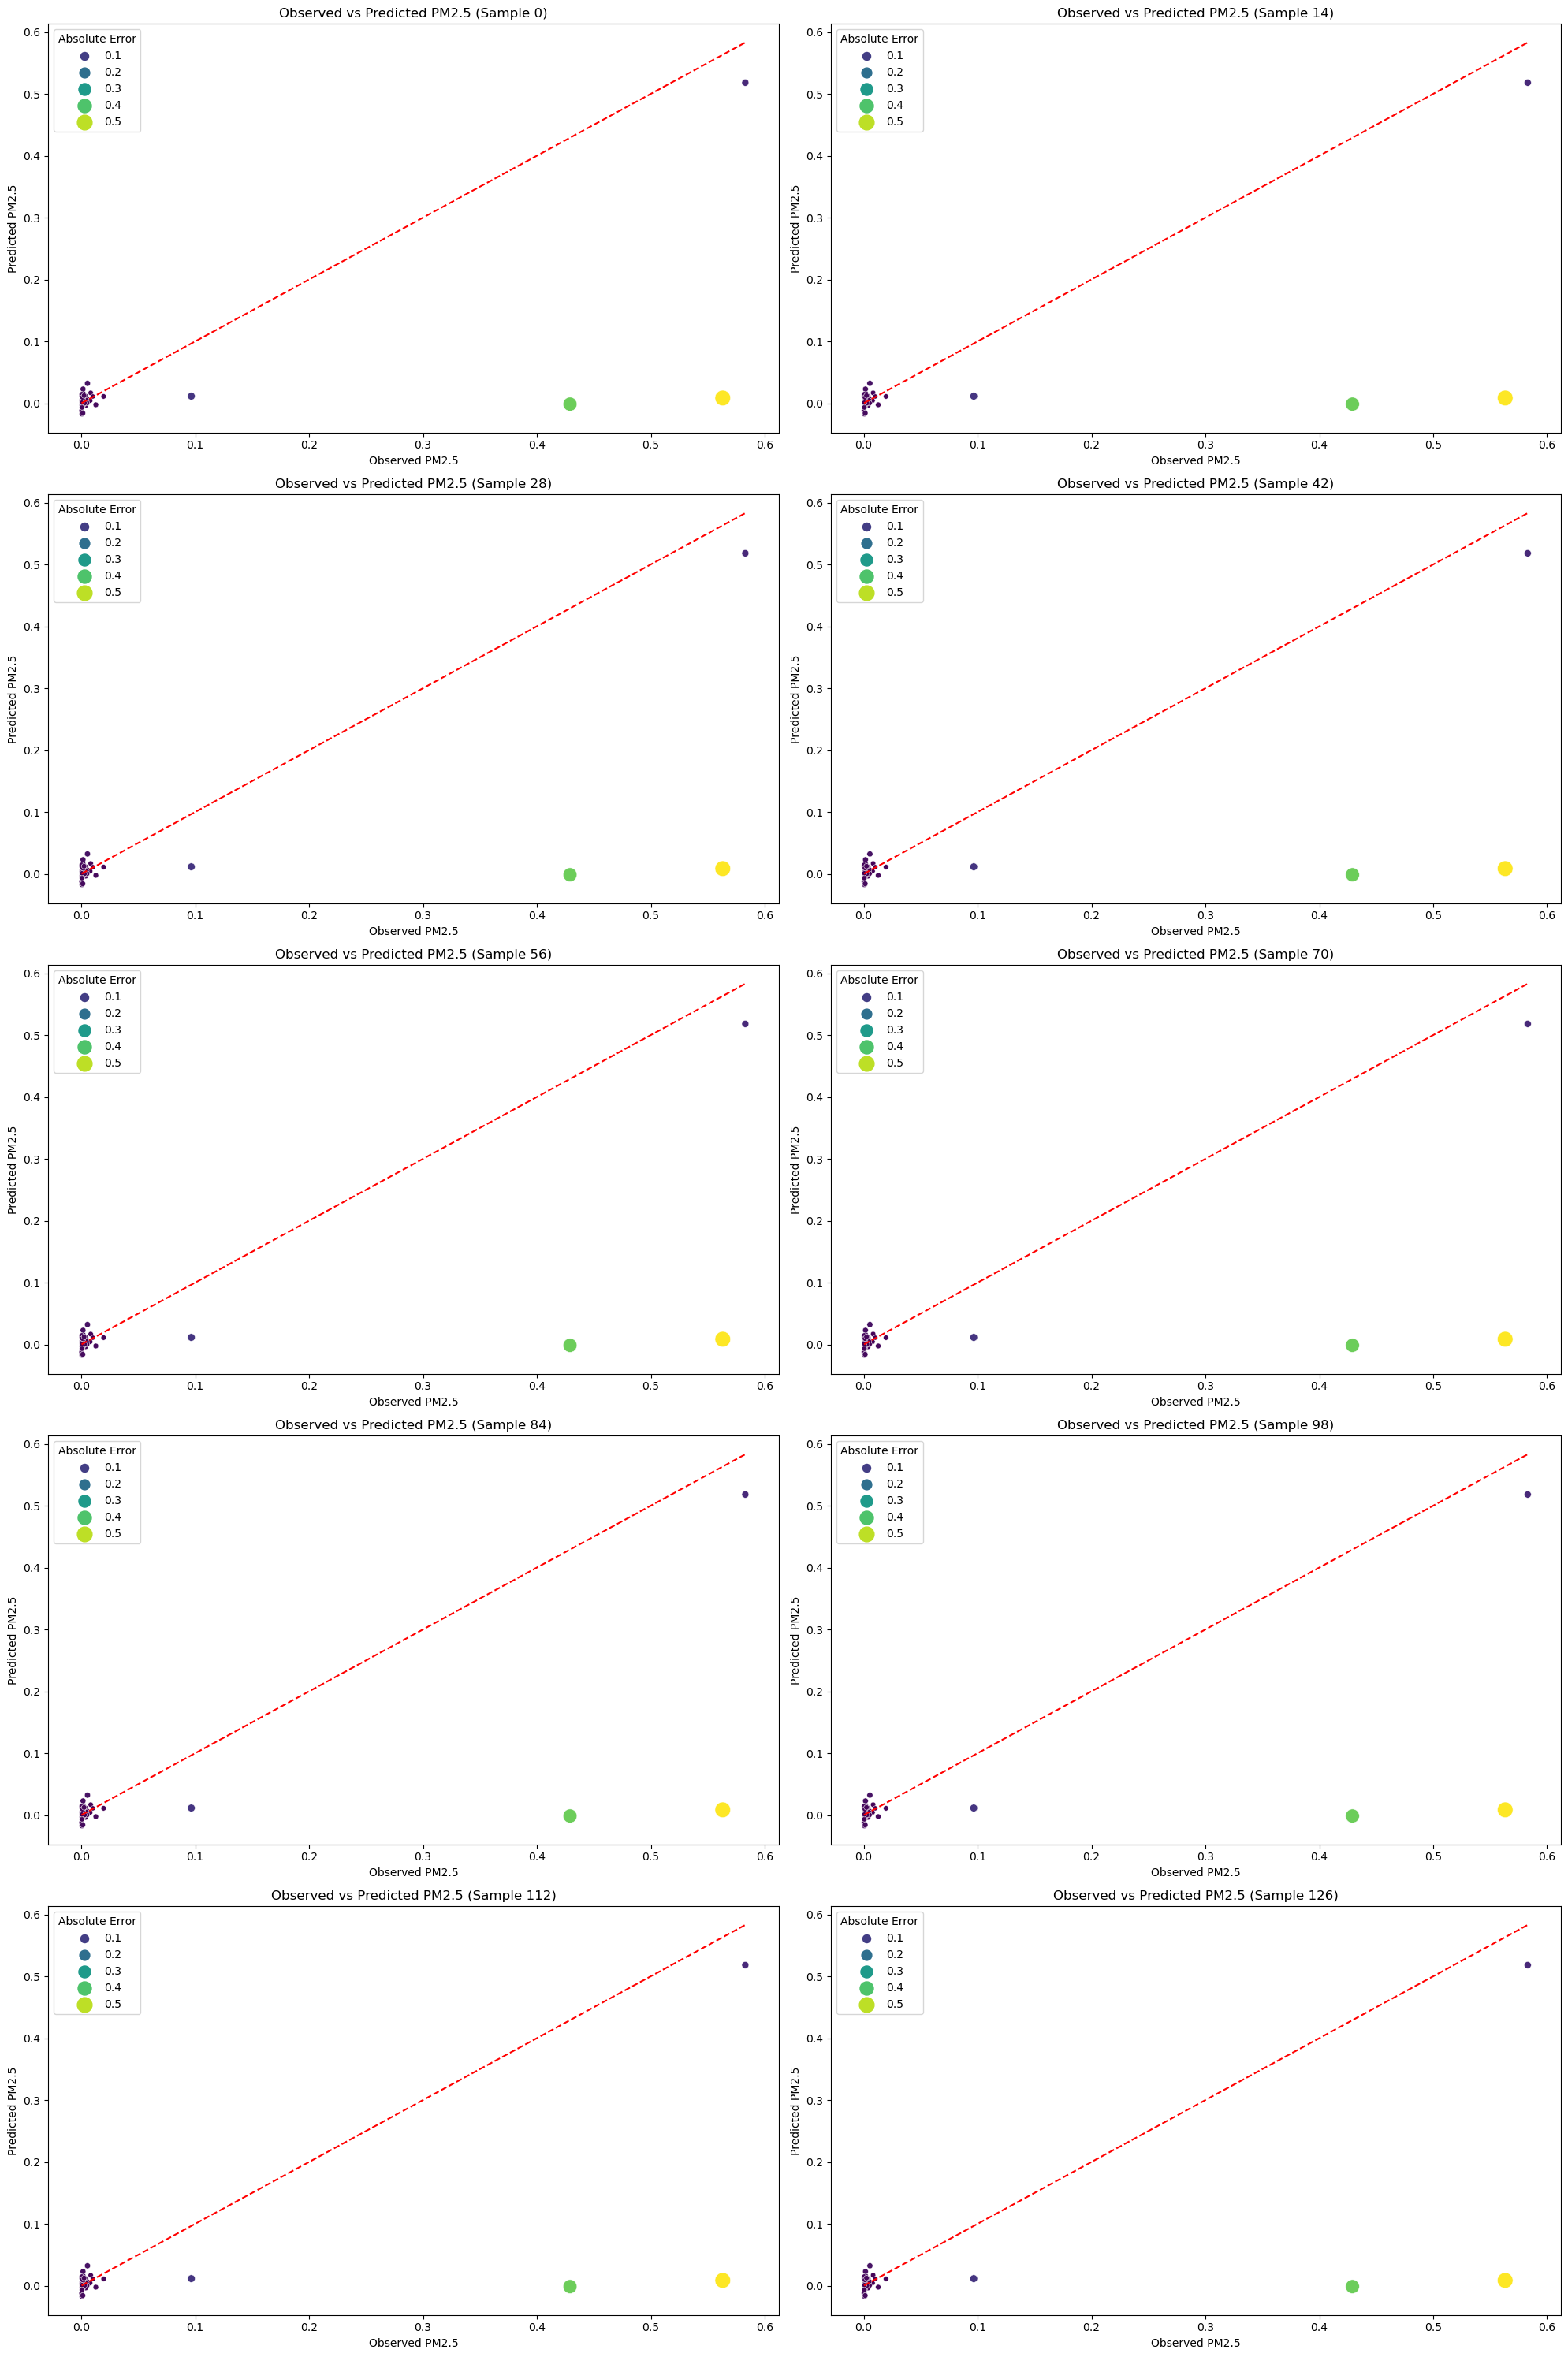

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 10
step_size = 14  # Set the step size to 11
rows = (num_samples + 1) // 2  # Calculate number of rows needed for 2 plots per row

fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for idx, i in enumerate(range(0, num_samples * step_size, step_size)):
    # Scatter plot of observed vs predicted values
    sns.scatterplot(ax=axes[idx], x='Observed_PM2.5', y='Predicted_PM2.5', data=results_data, hue='Absolute_Error', palette='viridis', size='Absolute_Error', sizes=(20, 200))
    axes[idx].plot([results_data['Observed_PM2.5'].min(), results_data['Observed_PM2.5'].max()], [results_data['Observed_PM2.5'].min(), results_data['Observed_PM2.5'].max()], color='red', linestyle='--')
    axes[idx].set_title(f'Observed vs Predicted PM2.5 (Sample {i})')
    axes[idx].set_xlabel('Observed PM2.5')
    axes[idx].set_ylabel('Predicted PM2.5')
    axes[idx].legend(title='Absolute Error')

# Remove any unused subplots
for ax in axes[len(range(0, num_samples * step_size, step_size)):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [4]:
# load files from a folder
import os
import pandas as pd
import glob

# Get a list of all the file paths in the folder
file_paths = glob.glob('../datasets/kriging_predictions/*')

# custom timestamp from 2022-04-01 to 2024-03-29
start_date = '2022-04-01'
end_date = '2024-03-29'
dates = pd.date_range(start_date, end_date).strftime('%Y-%m-%d')

# loop through the file paths and add a new column with the timestamp
dfs = []
for i, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    df['time_stamp'] = dates[i]
    dfs.append(df)

# Concatenate all the DataFrames
kriging_data = pd.concat(dfs)


In [5]:
kriging_data

,estimate,standard_error,x,y,time_stamp
0,8.596788,0.000000,0.000890,0.591812,2022-04-01
1,8.596788,0.000000,0.001836,0.591812,2022-04-01
2,8.596788,0.000000,0.002782,0.591812,2022-04-01
3,8.596788,0.000000,0.003728,0.591812,2022-04-01
4,8.596788,0.000000,-0.001002,0.592950,2022-04-01
...,...,...,...,...,...
492,2.692757,4.094771,0.000075,0.623084,2024-03-29
493,2.697743,4.094274,0.001116,0.623084,2024-03-29
494,2.725378,4.098998,0.002157,0.623084,2024-03-29
495,2.766913,4.107095,0.003198,0.623084,2024-03-29


In [10]:
import pyproj
import pandas as pd

# # Sample data: replace with your actual kriging data (normalized coordinates)
# kriging_data = pd.DataFrame({
#     'x': [0, 180],  # Example normalized x values
#     'y': [90, 0]    # Example normalized y values
# })

# Denormalize the coordinates (reverse the normalization applied by mapproject)
# Assuming original normalization to [-2, 2] for longitude and [-1, 1] for latitude:
kriging_data['x'] = kriging_data['x'] * (20037510 / 2)
kriging_data['y'] = kriging_data['y'] * (242485900 / 2)

# Define the projection systems
wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 coordinate system
mercator = pyproj.CRS('EPSG:3857')  # Mercator coordinate system

# Create a transformer to convert from Mercator to WGS84
transformer = pyproj.Transformer.from_crs(mercator, wgs84, always_xy=True)

# Apply the transformer to convert x and y from Mercator to longitude and latitude
kriging_data['longitude'], kriging_data['latitude'] = transformer.transform(kriging_data['x'].values, kriging_data['y'].values)

# Display the transformed data
print(kriging_data)


     estimate  standard_error             x             y  time_stamp  \
0    8.596788        0.000000  8.952294e+17  8.715860e+22  2022-04-01   
1    8.596788        0.000000  1.846651e+18  8.715860e+22  2022-04-01   
2    8.596788        0.000000  2.798072e+18  8.715860e+22  2022-04-01   
3    8.596788        0.000000  3.749493e+18  8.715860e+22  2022-04-01   
4    8.596788        0.000000 -1.007613e+18  8.732630e+22  2022-04-01   
..        ...             ...           ...           ...         ...   
492  2.692757        4.094771  7.560829e+16  9.176423e+22  2024-03-29   
493  2.697743        4.094274  1.122372e+18  9.176423e+22  2024-03-29   
494  2.725378        4.098998  2.169136e+18  9.176423e+22  2024-03-29   
495  2.766913        4.107095  3.215900e+18  9.176423e+22  2024-03-29   
496  2.820748        4.118601  4.262663e+18  9.176423e+22  2024-03-29   

      longitude  latitude  
0     58.084876      90.0  
1    -96.528750      90.0  
2    108.744990      90.0  
3    -45.06